In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response


In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

In [3]:
"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [4]:
## SIMPLE RELU

In [5]:
# 1. Training functions
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def gen_batch_sparse(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

def train_with_AdamW(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    n_steps: int,
    lr: float,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []
    
    optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        
         # Add this block to update the learning rate
        current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

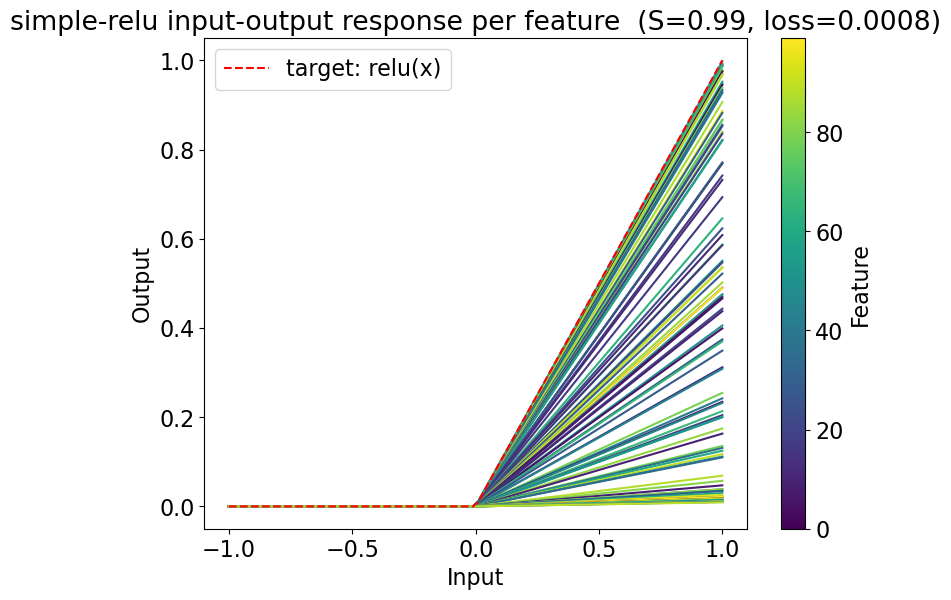

In [6]:
"""1. Define SIMPLE RELU MODEL - S =0.99"""
layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

"""Train a ReLU at S=0.99 and assess performance at different sparsity levels"""

# 1. Train the simple ReLU model on S=0.99 input
relu_cis = Cis(simple_relu_cfg, device=device)

lr = 3e-3
batch_sz = 2048
feat_sparsity = 0.99
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 100
#optimizer = t.optim.Adam(relu_cis.parameters())

losses = train_with_AdamW(
        relu_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)

"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

loss_data_simpleRelu99 = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(relu_cis, n_examples, s)
        
        # compute mean loss
        y = relu_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_simpleRelu99.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

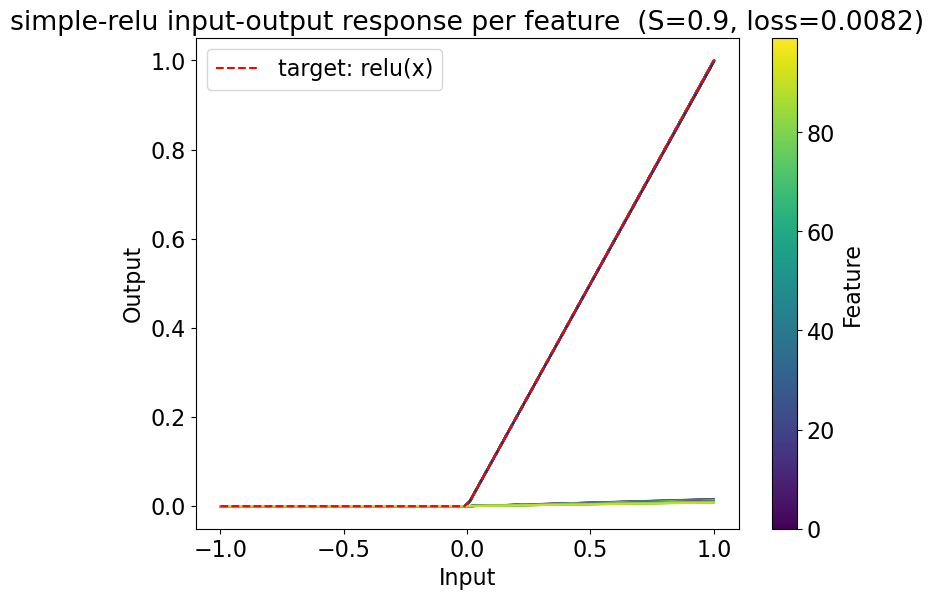

In [7]:
"""1. Define SIMPLE RELU MODEL - S =0.99"""
layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

"""Train a ReLU at S=0.99 and assess performance at different sparsity levels"""

# 1. Train the simple ReLU model on S=0.99 input
relu_cis90 = Cis(simple_relu_cfg, device=device)

lr = 3e-3
batch_sz = 2048
feat_sparsity = 0.90
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 100
#optimizer = t.optim.Adam(relu_cis.parameters())

losses = train_with_AdamW(
        relu_cis90,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)

"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 2048
feat_importance = 1
logging_freq = n_steps // 10

loss_data_simpleRelu90 = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(relu_cis, n_examples, s)
        
        # compute mean loss
        y = relu_cis90.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_simpleRelu90.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})


In [8]:
## simple relu onehot

In [9]:
"""Create functions for generating batches, loss, and training for the one-hot model."""

def gen_batch(model: Cis, batch_sz: int) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    x = t.zeros(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device)
    active_positions = t.randint(
            0, model.cfg.n_feat, (batch_sz, model.cfg.n_instances), device=device
    )
    active_values = t.randint(0, 2, (batch_sz, model.cfg.n_instances), device=device) * 2.0 - 1
    
    # Create index tensors for vectorized assignment
    batch_idx = t.arange(batch_sz, device=device).view(-1, 1).expand(-1, model.cfg.n_instances)
    instance_idx = t.arange(model.cfg.n_instances, device=device).expand(batch_sz, -1)
    x[batch_idx, instance_idx, active_positions] = active_values
    
    return x, t.relu(x)

def gen_batch_sparse(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)
    
def loss_fn(y: Float[Tensor, "batch inst feat"], y_true: Float[Tensor, "batch inst feat"]) -> Float:
    active_weight, inactive_weight = 10, 1
    weights = t.where(y_true == 1, active_weight, inactive_weight)
    wmse = weights * (y - y_true) ** 2
    return reduce(wmse, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

def train_with_AdamW_onehot(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    n_steps: int,
    lr: float,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []
    
    optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true)
        
         # Add this block to update the learning rate
        current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.04808676242828369,
 0.004451950080692768,
 0.004585979040712118,
 0.0042580110020935535,
 0.004556857980787754,
 0.004602531902492046,
 0.004582860041409731,
 0.004553684499114752,
 0.004523467272520065,
 0.004557670094072819,
 0.004641570150852203]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

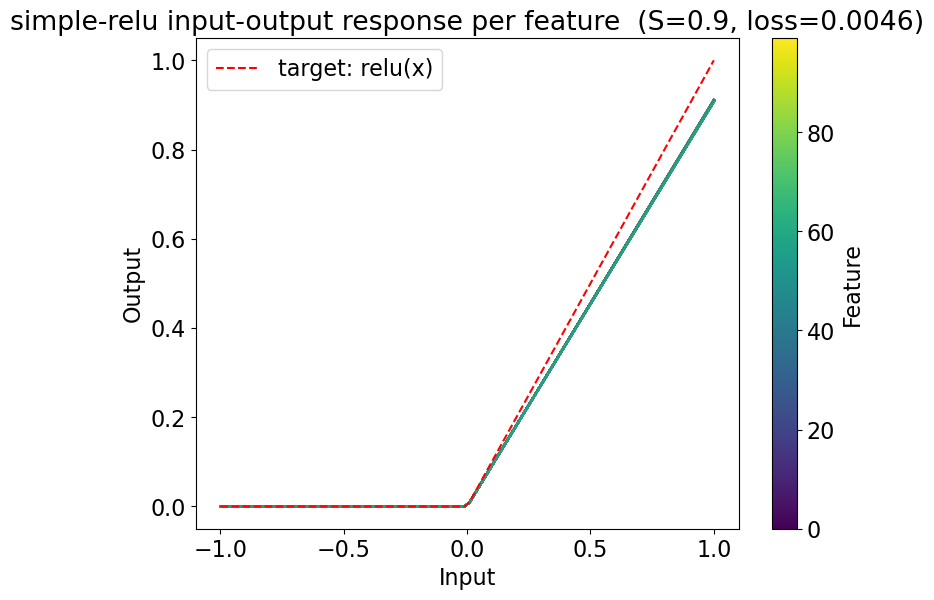

In [10]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

relu_onehot_cis_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

relu_onehot_cis = Cis(relu_onehot_cis_cfg, device=device).to(device)


batch_sz = 2048
n_steps = 10000
logging_freq = n_steps // 10
#optimizer = t.optim.Adam(relu_onehot_cis.parameters())

losses = train_with_AdamW_onehot(
        relu_onehot_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 2048
feat_importance = 1
logging_freq = n_steps // 10
poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data_oneHot = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(relu_onehot_cis, n_examples, s)
        
        # compute mean loss
        y = relu_onehot_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_oneHot.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

In [11]:
## RELU_PLUSX_NOEMBED

In [12]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def gen_batch_sparse(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.0016729289200156927,
 0.0008643390028737485,
 0.0008165164617821574,
 0.0008550649508833885,
 0.000869978335686028,
 0.0008092327043414116,
 0.0007866682135500014,
 0.0008787531987763941,
 0.0008636837010271847,
 0.0008609469514340162,
 0.000873334298375994]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

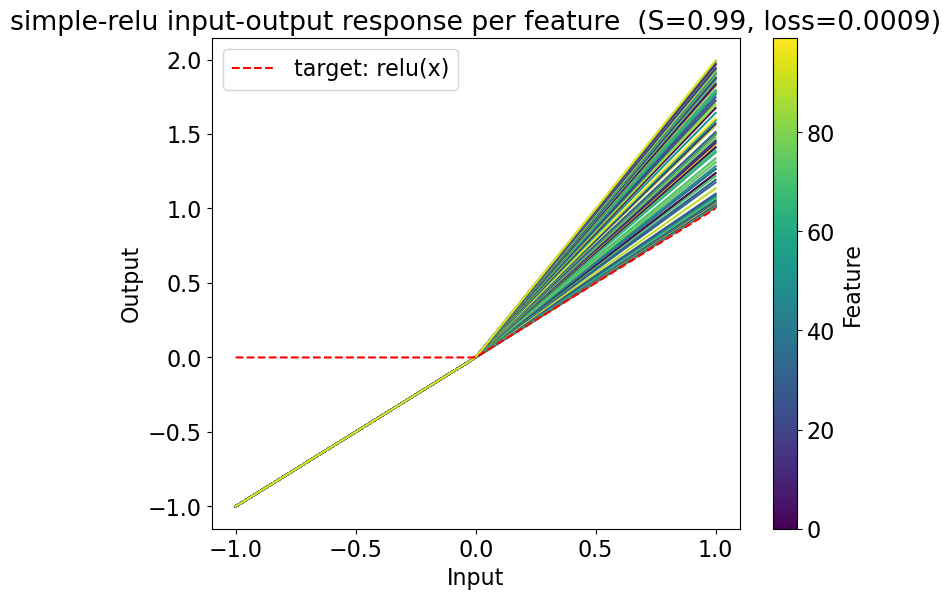

In [13]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

batch_sz = 2048
feat_sparsity = 0.99
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(reluPlusX_res_noEmbed_cis.parameters())

losses = train_with_AdamW(
        reluPlusX_res_noEmbed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 2048
feat_importance = 1
logging_freq = n_steps // 10

loss_data_reluPlusNoEmbed = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(reluPlusX_res_noEmbed_cis, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_noEmbed_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_reluPlusNoEmbed.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.016761749982833862,
 0.008271313272416592,
 0.007946769706904888,
 0.008031082339584827,
 0.007934455759823322,
 0.008170530200004578,
 0.008145744912326336,
 0.007812398485839367,
 0.008135774172842503,
 0.00793504249304533,
 0.008315958082675934]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

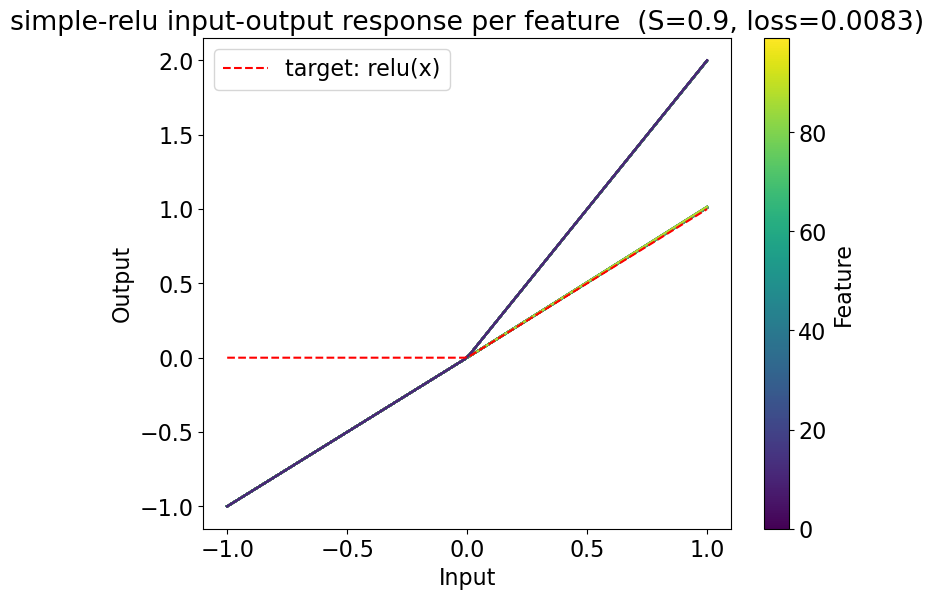

In [14]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

reluPlusX_res_noEmbed_cis90 = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

batch_sz = 2048
feat_sparsity = 0.90
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 10
#optimizer = t.optim.Adam(reluPlusX_res_noEmbed_cis.parameters())

losses = train_with_AdamW(
        reluPlusX_res_noEmbed_cis90,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 2048
feat_importance = 1
logging_freq = n_steps // 10

loss_data_reluPlusNoEmbed90 = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(reluPlusX_res_noEmbed_cis90, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_noEmbed_cis90.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_reluPlusNoEmbed90.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})


In [15]:
## RELU_PLUSX_EMBED MODELS

In [16]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.0018578877206891775,
 0.0007300174911506474,
 0.0006726288702338934,
 0.0006334005738608539,
 0.0007248500478453934,
 0.0007081021321937442,
 0.0006551985861733556,
 0.0006399048143066466,
 0.0006434796378016472,
 0.0006622534710913897,
 0.0006532573606818914]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

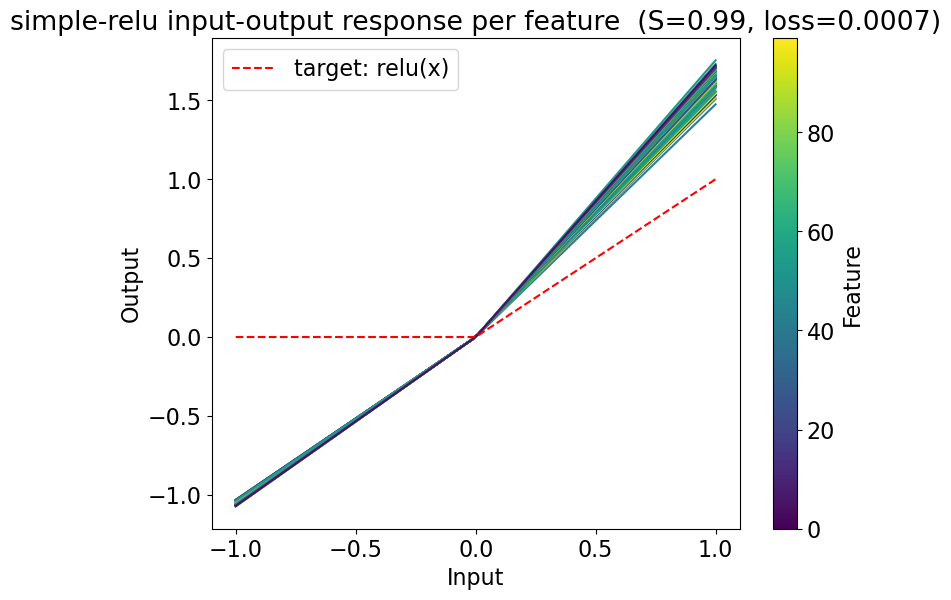

In [17]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)

batch_sz = 2048
feat_sparsity = 0.99
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 10
#optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters(), lr=5e-4)

losses = train_with_AdamW(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 2048
feat_importance = 1
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data_reluPlusEmbed = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(reluPlusX_res_embed_cis, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_embed_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_reluPlusEmbed.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.019753122702240944,
 0.007700375281274319,
 0.007832829840481281,
 0.007713207043707371,
 0.007922406308352947,
 0.0076137748546898365,
 0.007748836185783148,
 0.007756946142762899,
 0.007778655271977186,
 0.007656058296561241,
 0.007753206416964531]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

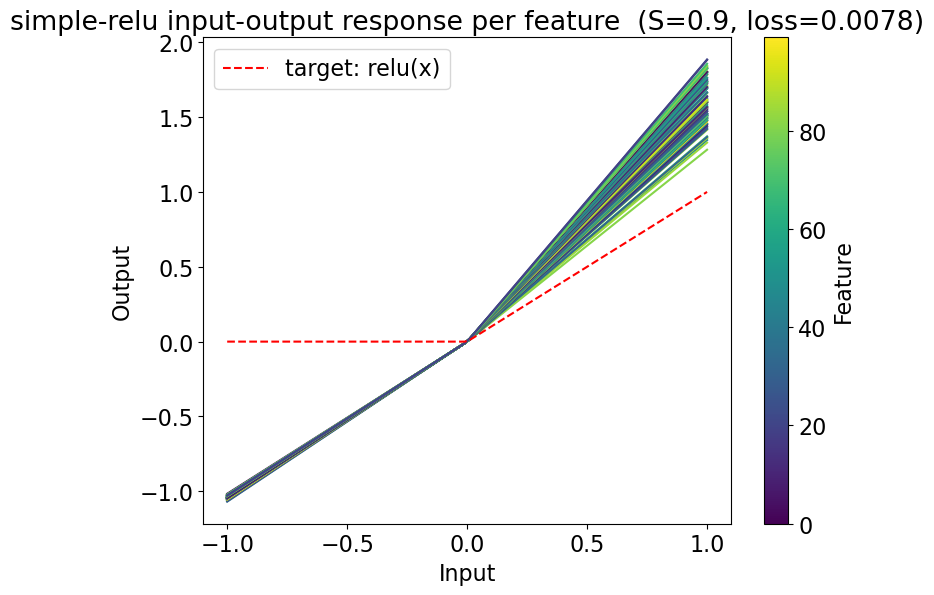

In [18]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

reluPlusX_res_embed_cis90 = Cis(reluPlusX_res_embed_cfg, device=device)

batch_sz = 2048
feat_sparsity = 0.90
feat_importance = 1
n_steps = 10000
logging_freq = n_steps // 10
#optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters(), lr=5e-4)

losses = train_with_AdamW(
        reluPlusX_res_embed_cis90,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 2048
feat_importance = 1
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data_reluPlusEmbed90 = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(reluPlusX_res_embed_cis90, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_embed_cis90.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_reluPlusEmbed90.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

In [19]:
df1 = pd.DataFrame(loss_data_simpleRelu99)
df2 = pd.DataFrame(loss_data_simpleRelu90)
df3 = pd.DataFrame(loss_data_oneHot)
df4 = pd.DataFrame(loss_data_reluPlusEmbed)
df5 = pd.DataFrame(loss_data_reluPlusNoEmbed)
df6 = pd.DataFrame(loss_data_reluPlusEmbed90)
df7 = pd.DataFrame(loss_data_reluPlusNoEmbed90)
loss =  np.array([50 * (1 - sparsities) / 6])

# Add a column to track the origin of each DataFrame
df1['source'] = 'Simple ReLU S=0.99'
df2['source'] = 'Simple ReLU S=0.90'
df3['source'] = 'Simple ReLU one-hot'
df4['source'] = 'ReLU_PlusX Embed S=0.99'
df5['source'] = 'ReLU_PlusX NoEmbed S=0.99'
df6['source'] = 'ReLU_PlusX Embed S=0.90'
df7['source'] = 'ReLU_PlusX NoEmbed S=0.90'

# Combine all DataFrames
df_combined = pd.concat([df1, df2, df3, df4, df5, df6, df7])

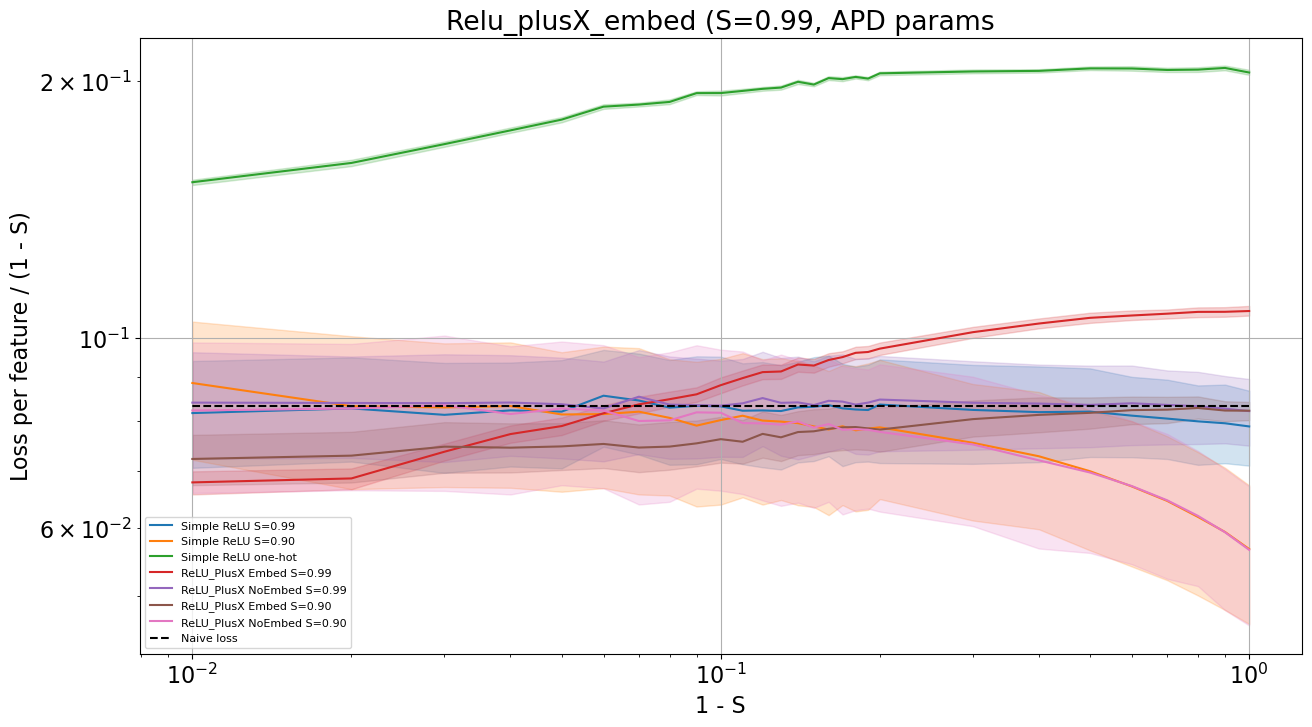

In [20]:
# Create figure of all sparsity values

df_combined["1-S"] = 1 - df_combined["sparsity"]
df_combined["loss/1-S"] = df_combined["loss_per_feature"] / (1 - df_combined["sparsity"])

naive_loss = 0.5 * (1 - sparsities) / 6

fig = plt.figure(figsize=(15, 8))
sns.lineplot(data = df_combined, x = "1-S", y = "loss/1-S", hue = "source")
norm_loss = naive_loss.ravel() / (1 - sparsities)
plt.plot(1- sparsities, norm_loss, linestyle="dashed", color="black", label=r"Naive loss")
plt.xlabel('1 - S')
#plt.ylim(0.008,0.021)
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(loc = "best", fontsize = 8)
plt.ylabel('Loss per feature / (1 - S)')
plt.title('Relu_plusX_embed (S=0.99, APD params')
plt.savefig("/workspace/models_APDtraining_log.png", dpi=200)
plt.show()

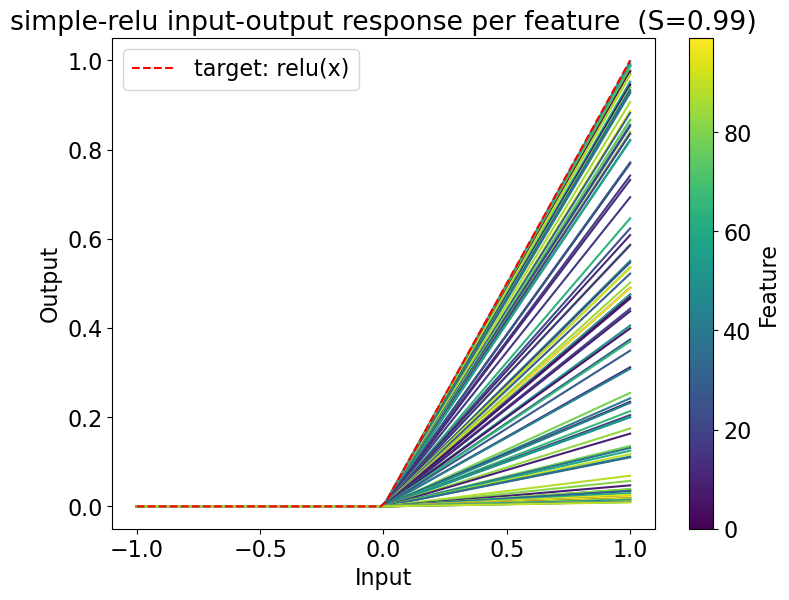

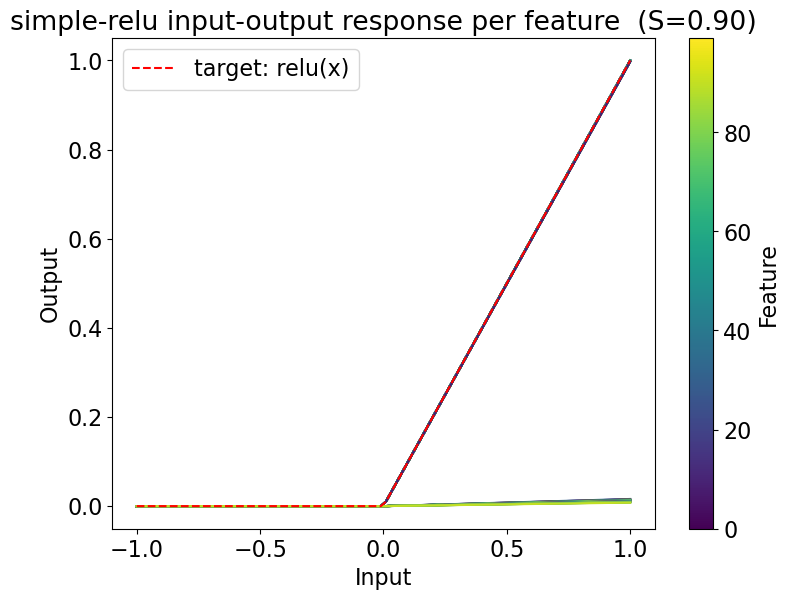

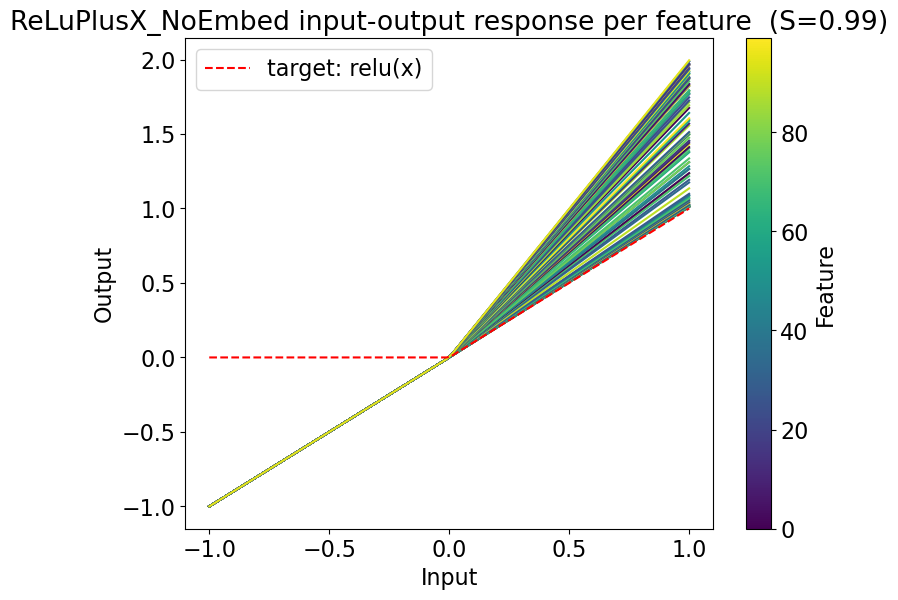

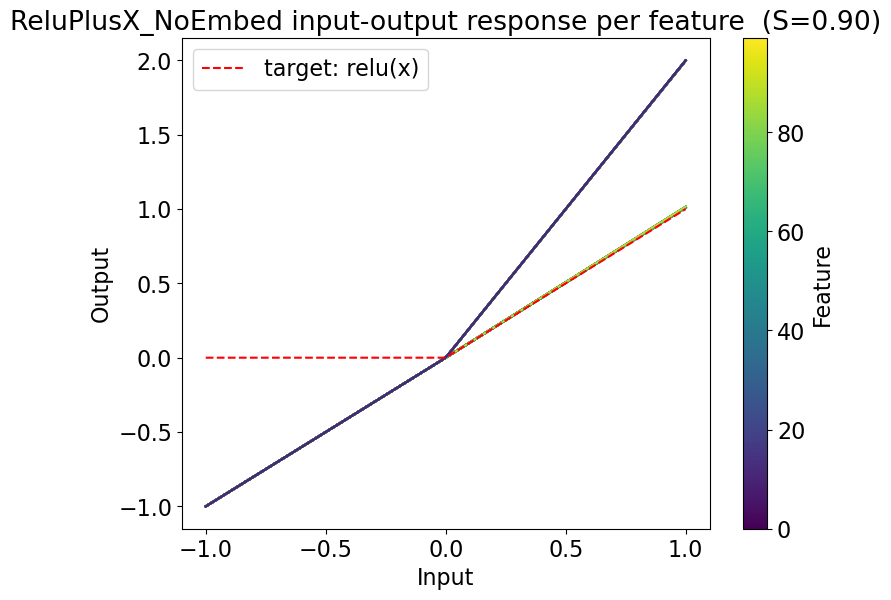

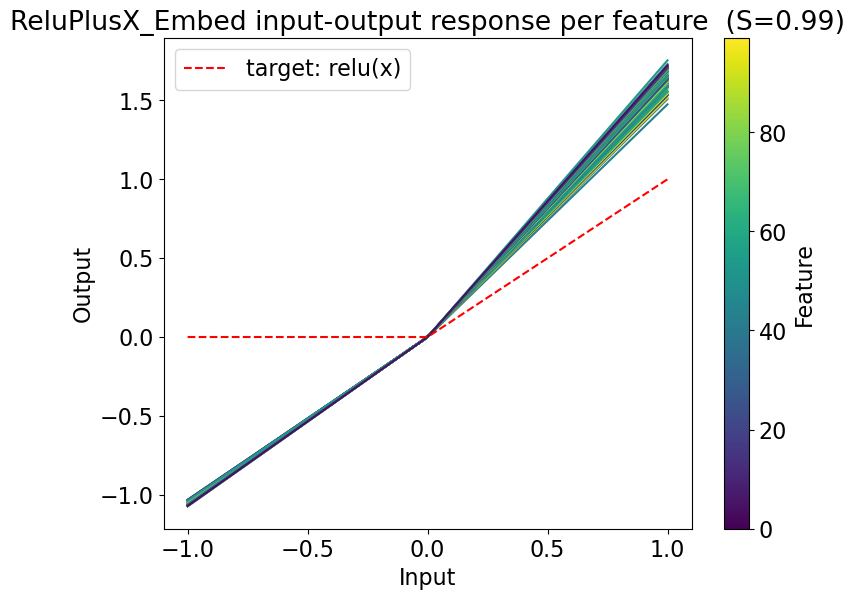

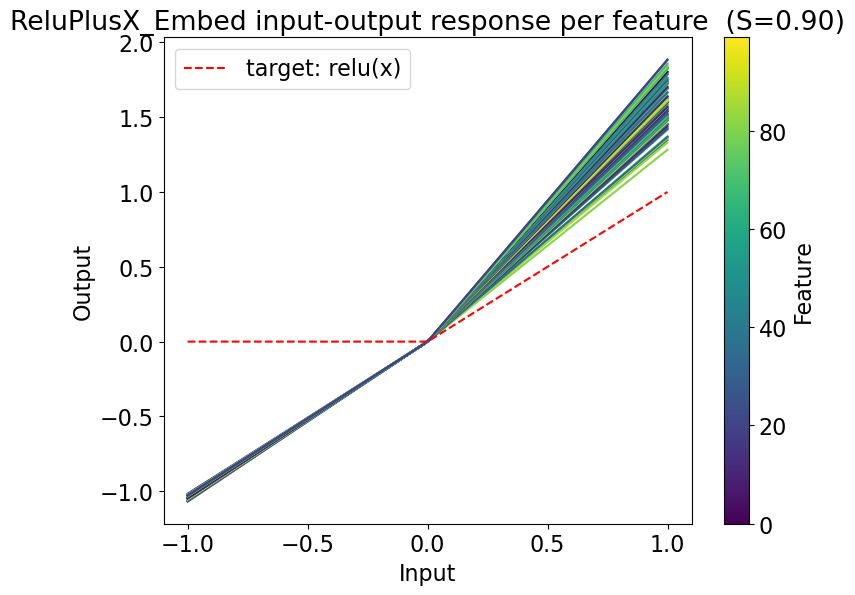

In [22]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"simple-relu input-output response per feature  (S=0.99)")
ax.legend()
plt.savefig("/workspace/simpleRelu_099_inputoutput.png", dpi=200)
plt.show()

"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(relu_cis90, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"simple-relu input-output response per feature  (S=0.90)")
ax.legend()
plt.savefig("/workspace/simpleRelu_090_inputoutput.png", dpi=200)
plt.show()

"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_noEmbed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"ReLuPlusX_NoEmbed input-output response per feature  (S=0.99)")
ax.legend()
plt.savefig("/workspace/ReluPlusX_NoEmbed_099_inputoutput.png", dpi=200)
plt.show()

"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_noEmbed_cis90, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"ReluPlusX_NoEmbed input-output response per feature  (S=0.90)")
ax.legend()
plt.savefig("/workspace/ReluPlusX_NoEmbed_090_inputoutput.png", dpi=200)
plt.show()

"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_embed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"ReluPlusX_Embed input-output response per feature  (S=0.99)")
ax.legend()
plt.savefig("/workspace/ReluPlusX_Embed_099_inputoutput.png", dpi=200)
plt.show()

"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_embed_cis90, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"ReluPlusX_Embed input-output response per feature  (S=0.90)")
ax.legend()
plt.savefig("/workspace/ReluPlusX_Embed_090_inputoutput.png", dpi=200)
plt.show()



W.shape=torch.Size([50, 100])
W.shape=torch.Size([50, 100])
W.shape=torch.Size([50, 100])
W.shape=torch.Size([50, 100])
W.shape=torch.Size([50, 100])
W.shape=torch.Size([50, 100])


Text(0.5, 1.0, 'ReLU_PlusX_Embed S = 0.90 feature weights per neuron')

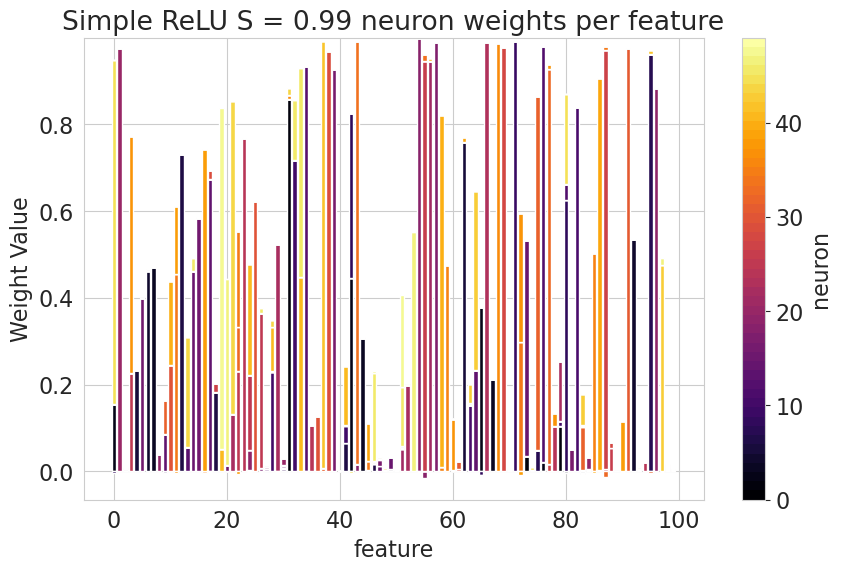

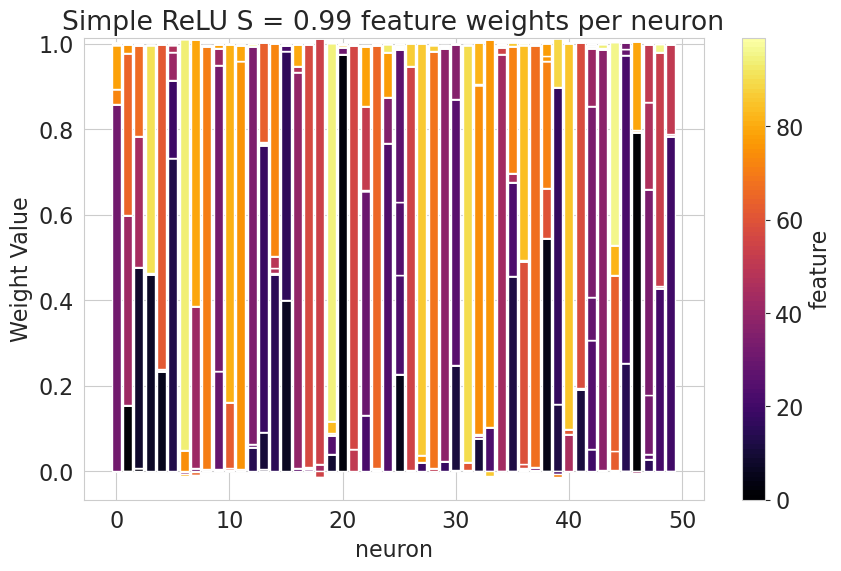

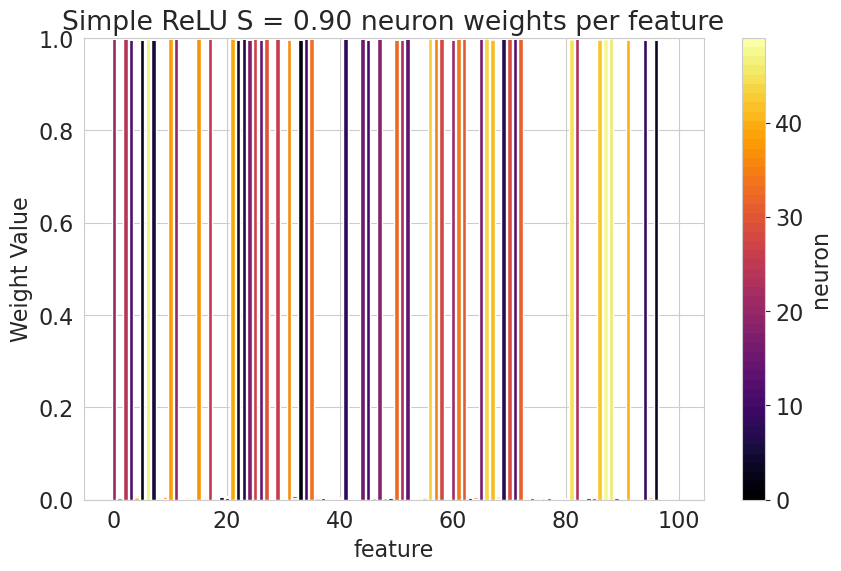

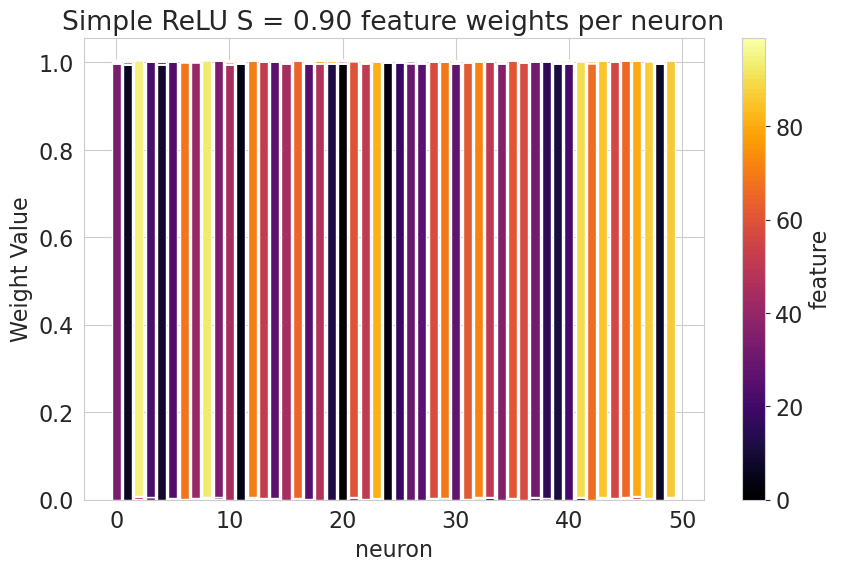

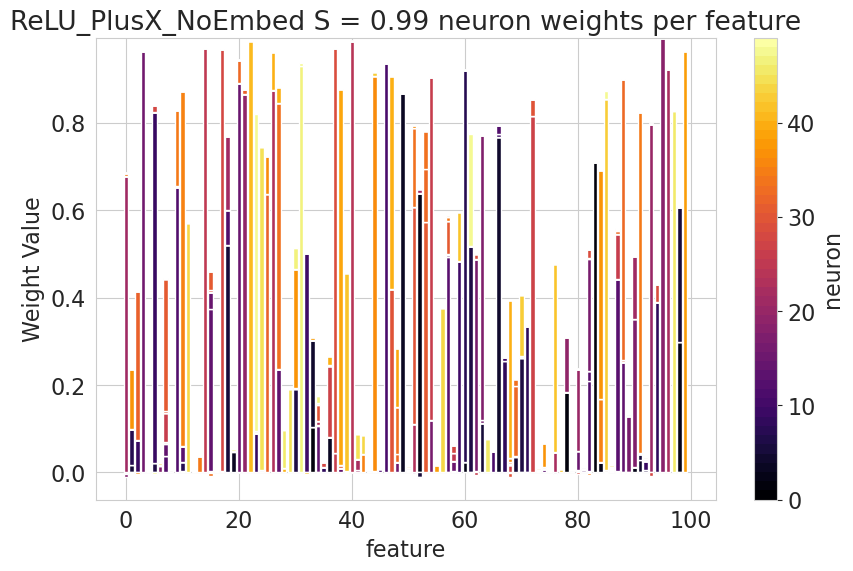

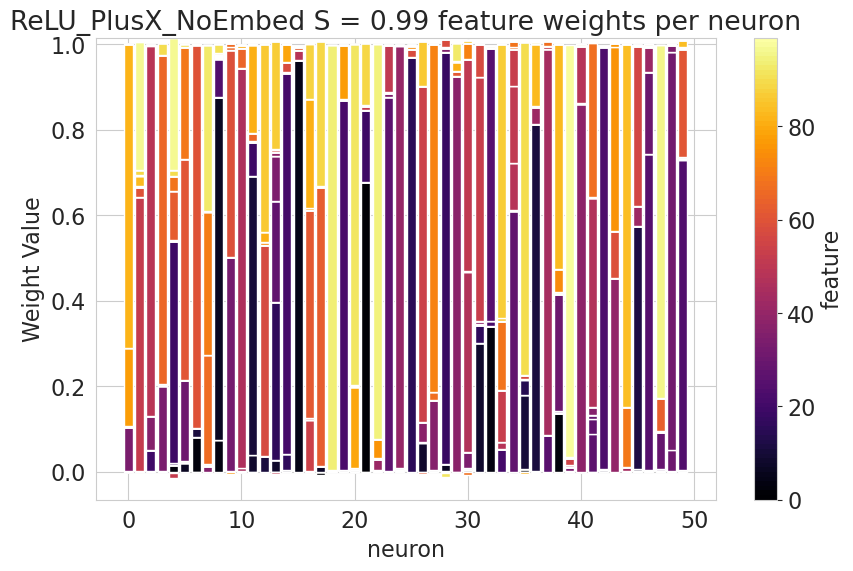

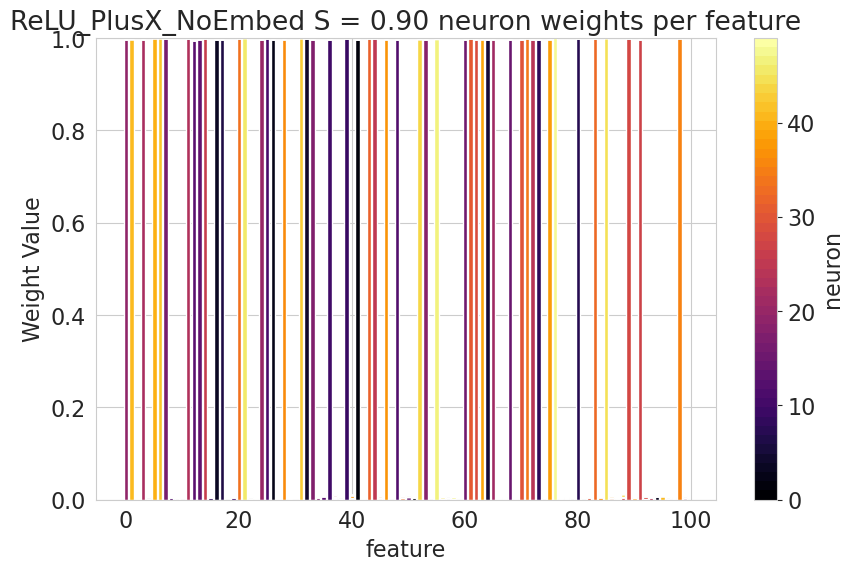

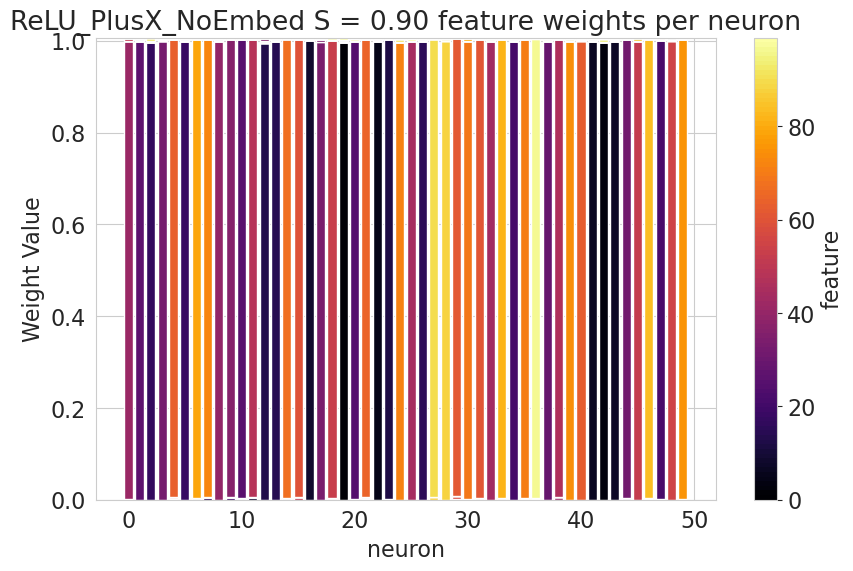

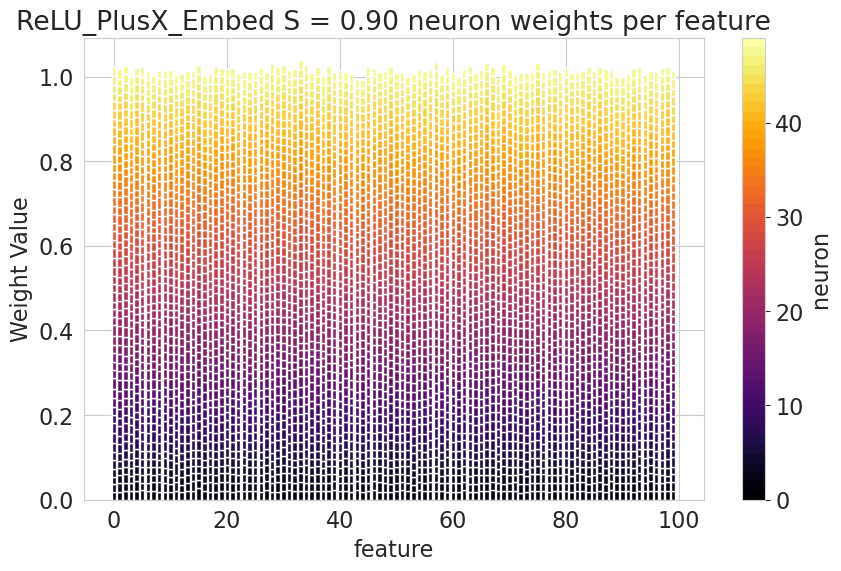

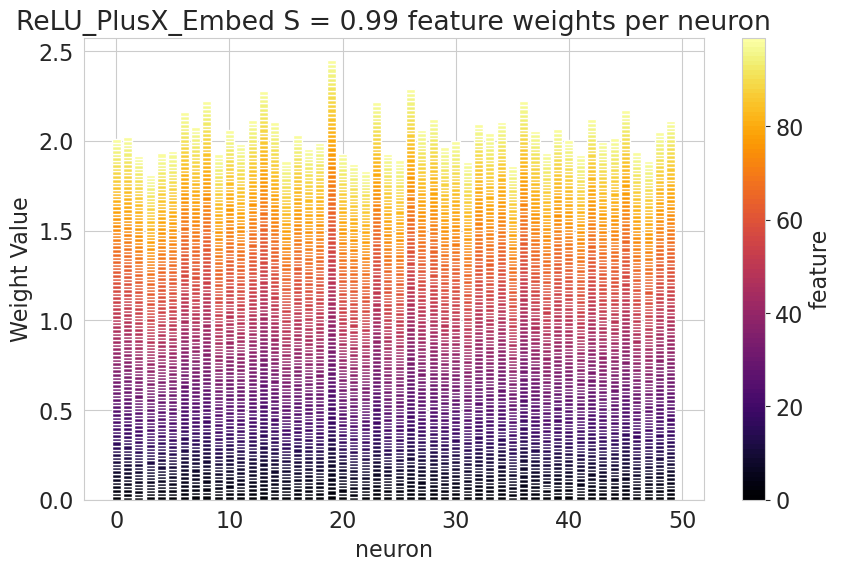

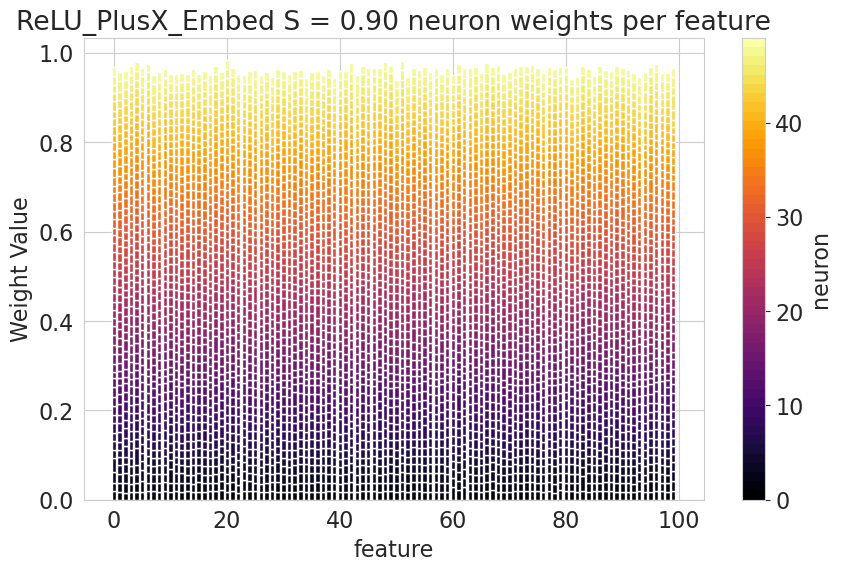

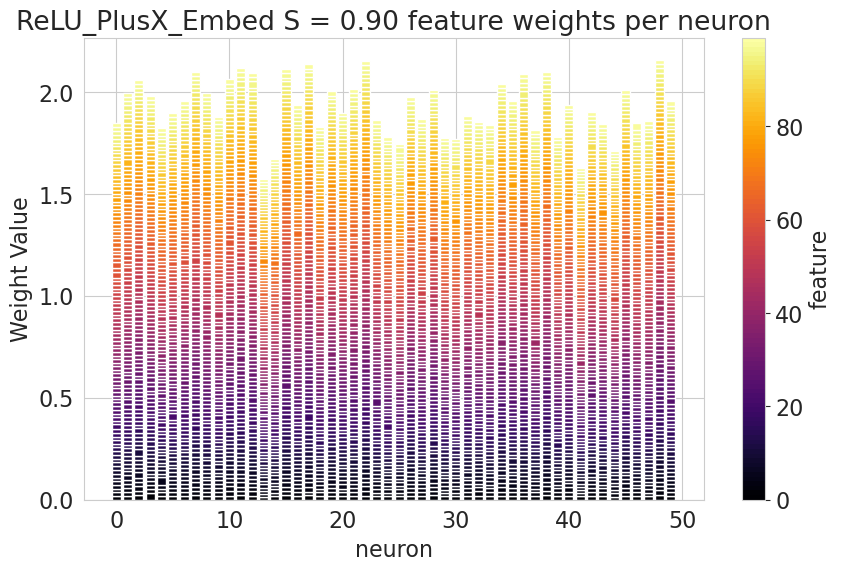

In [25]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(relu_cis.W1, relu_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("Simple ReLU S = 0.99 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("Simple ReLU S = 0.99 feature weights per neuron")

"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(relu_cis90.W1, relu_cis90.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("Simple ReLU S = 0.90 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("Simple ReLU S = 0.90 feature weights per neuron")

"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(reluPlusX_res_noEmbed_cis.W1, reluPlusX_res_noEmbed_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.99 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.99 feature weights per neuron")

"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(reluPlusX_res_noEmbed_cis90.W1, reluPlusX_res_noEmbed_cis90.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.90 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.90 feature weights per neuron")

"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(
    reluPlusX_res_embed_cis.We,
    reluPlusX_res_embed_cis.W1,
    reluPlusX_res_embed_cis.W2,
    reluPlusX_res_embed_cis.Wu,
    "inst emb feat, inst neuron emb, inst emb neuron, inst feat emb -> neuron feat"
) * reluPlusX_res_embed_cfg.We_dim / reluPlusX_res_embed_cfg.n_feat
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_Embed S = 0.90 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_Embed S = 0.99 feature weights per neuron")

"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(
    reluPlusX_res_embed_cis90.We,
    reluPlusX_res_embed_cis90.W1,
    reluPlusX_res_embed_cis90.W2,
    reluPlusX_res_embed_cis90.Wu,
    "inst emb feat, inst neuron emb, inst emb neuron, inst feat emb -> neuron feat"
) * reluPlusX_res_embed_cfg.We_dim / reluPlusX_res_embed_cfg.n_feat
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_Embed S = 0.90 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_Embed S = 0.90 feature weights per neuron")

In [26]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [35]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

reluPlusX_res_embed_cis40k = Cis(reluPlusX_res_embed_cfg, device=device)

batch_sz = 2048
feat_sparsity = 0.99
feat_importance = 1
n_steps = 160000
logging_freq = n_steps // 10
#optimizer = t.optim.Adam(reluPlusX_res_embed_cis.parameters(), lr=5e-4)

losses = train_with_AdamW(
        reluPlusX_res_embed_cis40k,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 2048
feat_importance = 1
logging_freq = n_steps // 10

poly_data = []  # will store all polysemanticity and weight data
loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data_reluPlusEmbed40k = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch_sparse(reluPlusX_res_embed_cis40k, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_embed_cis40k.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data_reluPlusEmbed40k.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

Training:   0%|          | 0/160000 [00:00<?, ?it/s]

[0.0020049617160111666,
 0.0007267316104844213,
 0.0006685782573185861,
 0.0006993323331698775,
 0.0006776223890483379,
 0.0007117323693819344,
 0.000692830653861165,
 0.0007101154769770801,
 0.0007055718451738358,
 0.0006673922762274742,
 0.0006637841579504311]

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

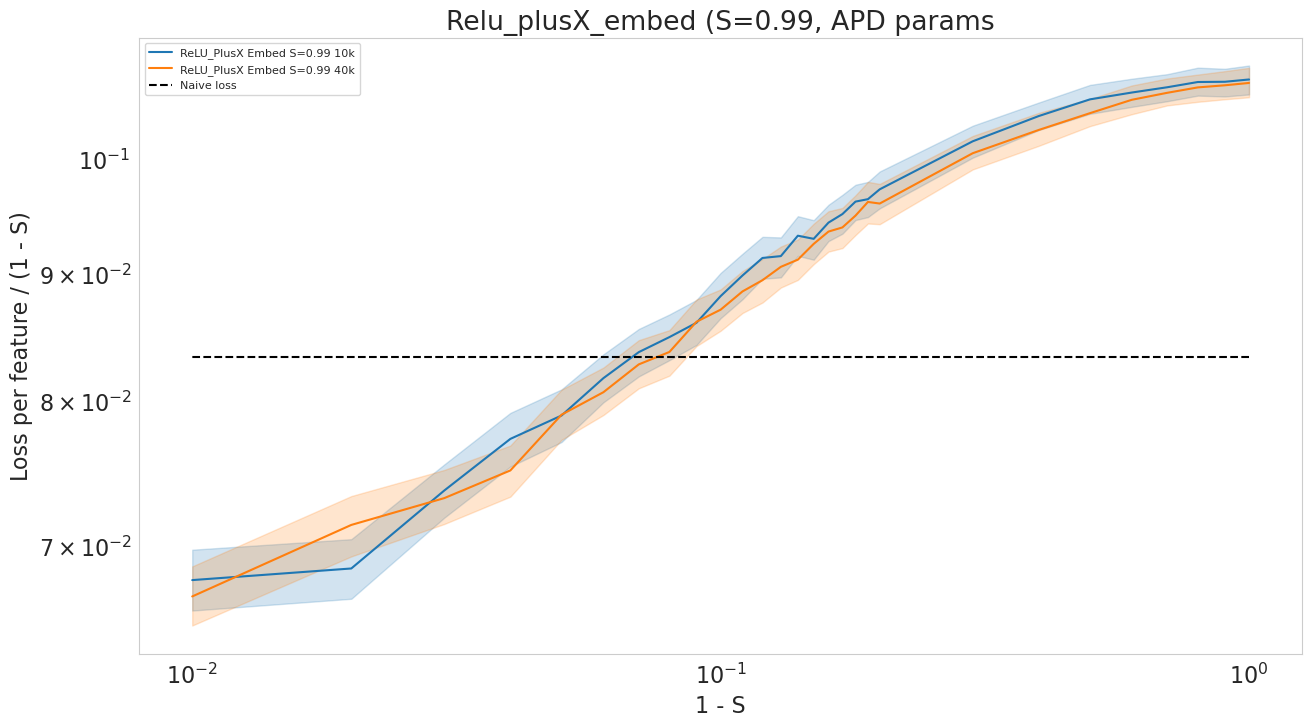

In [36]:
# Create figure of all sparsity values
df4 = pd.DataFrame(loss_data_reluPlusEmbed)
df5 = pd.DataFrame(loss_data_reluPlusEmbed40k)
df4['source'] = 'ReLU_PlusX Embed S=0.99 10k'
df5['source'] = 'ReLU_PlusX Embed S=0.99 40k'
df_combined = pd.concat([df4, df5])
df_combined["1-S"] = 1 - df_combined["sparsity"]
df_combined["loss/1-S"] = df_combined["loss_per_feature"] / (1 - df_combined["sparsity"])

# Combine all DataFrames
df_loss = pd.DataFrame(loss_data_reluPlusEmbed40k)
df_loss["1-S"] = 1 - df_loss["sparsity"]
df_loss["loss/1-S"] = df_loss["loss_per_feature"] / (1 - df_loss["sparsity"])

naive_loss = 0.5 * (1 - sparsities) / 6

fig = plt.figure(figsize=(15, 8))
sns.lineplot(data = df_combined, x = "1-S", y = "loss/1-S", hue = "source")
norm_loss = naive_loss.ravel() / (1 - sparsities)
plt.plot(1- sparsities, norm_loss, linestyle="dashed", color="black", label=r"Naive loss")
plt.xlabel('1 - S')
#plt.ylim(0.008,0.021)
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(loc = "best", fontsize = 8)
plt.ylabel('Loss per feature / (1 - S)')
plt.title('Relu_plusX_embed (S=0.99, APD params')
#plt.savefig("/workspace/models_APDtraining_log.png", dpi=200)
plt.show()

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, 'ReLU_PlusX_Embed S = 0.99 feature weights per neuron')

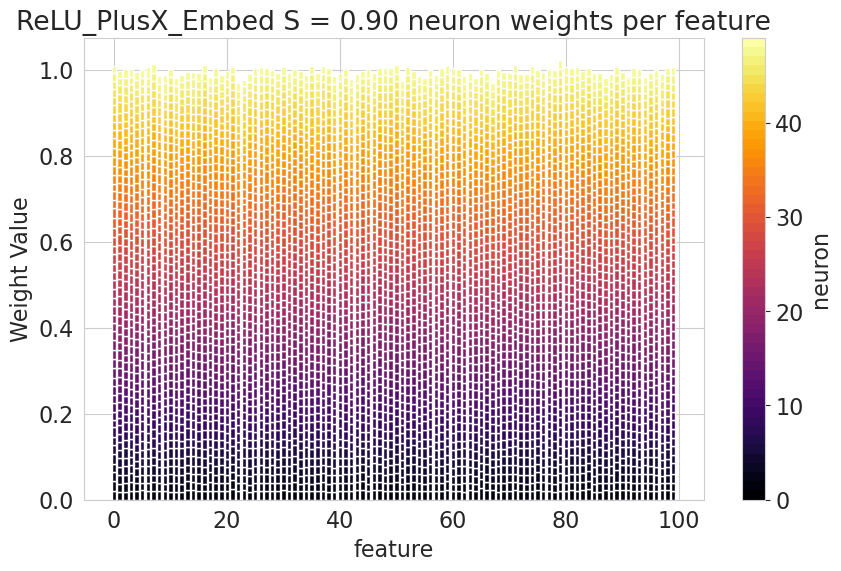

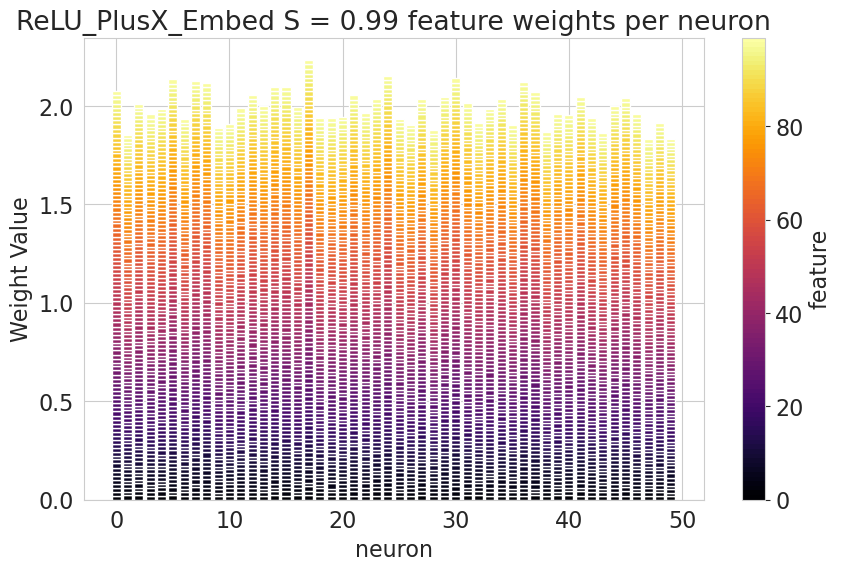

In [37]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(
    reluPlusX_res_embed_cis40k.We,
    reluPlusX_res_embed_cis40k.W1,
    reluPlusX_res_embed_cis40k.W2,
    reluPlusX_res_embed_cis40k.Wu,
    "inst emb feat, inst neuron emb, inst emb neuron, inst feat emb -> neuron feat"
) * reluPlusX_res_embed_cfg.We_dim / reluPlusX_res_embed_cfg.n_feat
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_Embed S = 0.90 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_Embed S = 0.99 feature weights per neuron")

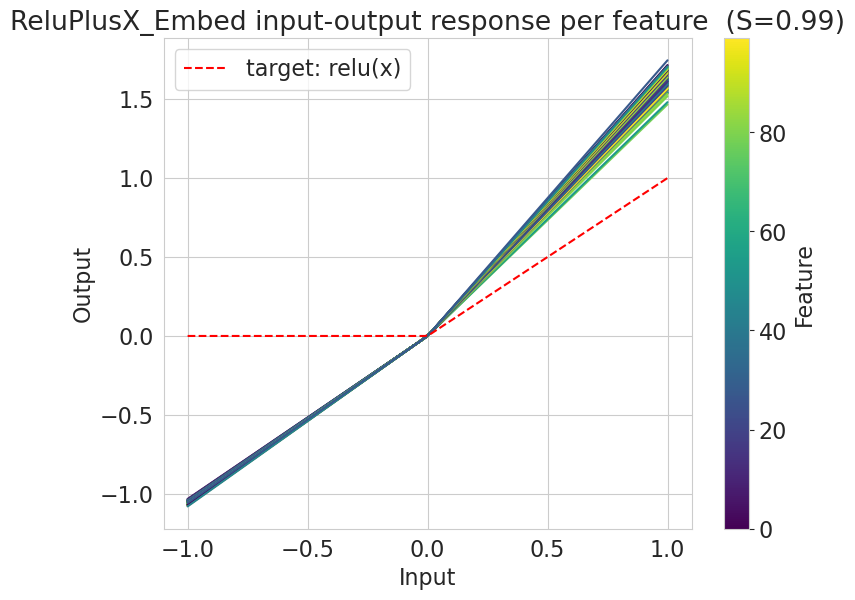

In [38]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_embed_cis40k, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"ReluPlusX_Embed input-output response per feature  (S=0.99)")
ax.legend()
#plt.savefig("/workspace/ReluPlusX_Embed_099_inputoutput.png", dpi=200)
plt.show()